In [1]:
%%capture
!pip install transformers

In [43]:
import pandas as pd
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import TFAutoModel
import tensorflow as tf

# Get Data

In [3]:
# Prepare Kaggle API:
from google.colab import files
# Install Kaggle library
!pip install -q kaggle
# Upload kaggle API key file
uploaded = files.upload()
# create the needed directory
! mkdir ~/.kaggle
# Copy the file to the dir
! cp kaggle.json ~/.kaggle/
# Change permissions:
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 36.5MB/s]
  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 154MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 81.7MB/s]


In [5]:
! unzip test.tsv.zip 
! unzip train.tsv.zip
! rm test.tsv.zip 
! rm train.tsv.zip

Archive:  test.tsv.zip
  inflating: test.tsv                
Archive:  train.tsv.zip
  inflating: train.tsv               


# Prepare Data

In [6]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [7]:
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [8]:
# Drop Duplicates:
train.drop_duplicates(subset="SentenceId", keep="first", inplace=True)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


<Figure size 1152x720 with 0 Axes>

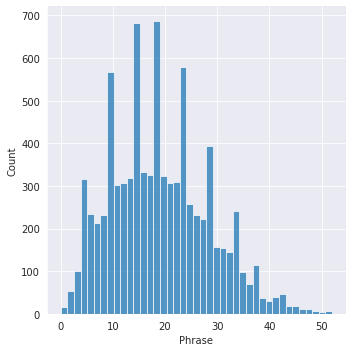

In [9]:
#Get the length of the phrase:
seqlen = train["Phrase"].apply(lambda x: len(x.split()))

# Plot stats:
sns.set_style("darkgrid")
plt.figure(figsize=(16, 10))
sns.displot(seqlen)

In [21]:
#Set our seqlen:
SEQ_LEN = 50
# Tokenize:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokens = tokenizer.encode_plus("Rose runs in the park", max_length=SEQ_LEN,
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors='tf')
# Prepare our array:
Xids = np.zeros((len(train), SEQ_LEN))
Xmask = np.zeros((len(train), SEQ_LEN))
for i, seq in enumerate(train['Phrase']):
  tokens = tokenizer.encode_plus(seq, max_length=SEQ_LEN,
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors='tf')
  Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

print('{} \n\n {}'.format(Xids, Xmask))

[[ 101.  138. 1326. ...    0.    0.    0.]
 [ 101. 1188. 3589. ...    0.    0.    0.]
 [ 101. 2431. 3899. ...    0.    0.    0.]
 ...
 [ 101.  118.  149. ...    0.    0.    0.]
 [ 101. 1109. 2523. ...    0.    0.    0.]
 [ 101. 1109. 1273. ...    0.    0.    0.]] 

 [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [27]:
#Work with Labels, one hot encode them:
arr =  train['Sentiment'].values
labels = np.zeros((arr.size, arr.max()+1))
labels[np.arange(arr.size), arr] = 1
print(labels)

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [34]:
#Save what we have done:
with open('xids.npy', 'wb') as f:
  np.save(f, Xids)
with open('mask.npy', 'wb') as f:
  np.save(f, Xmask)
with open('labels.npy', 'wb') as f:
  np.save(f, labels)

#Remove from Main Memory:
del train, Xids, Xmask, labels

# How to Load:
with open('xids.npy', 'rb') as f:
  Xids = np.load(f)
with open('mask.npy', 'rb') as f:
  Xmask = np.load(f)
with open('labels.npy', 'rb') as f:
  labels = np.load(f)

In [42]:
# generate Df for tf:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

#Make on the right form:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

dataset = dataset.map(map_func)

# Shuffle:
dataset = dataset.shuffle(1000000).batch(32)

# Split:
DS_LEN = len(list(dataset))
SPLIT = 0.9

train = dataset.take(round(DS_LEN*SPLIT))
val = dataset.skip(round(DS_LEN*SPLIT))

for i in train.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(32, 50), dtype=float64, numpy=
array([[  101.,  1188.,  2812., ...,     0.,     0.,     0.],
       [  101.,   146.,  1138., ...,     0.,     0.,     0.],
       [  101.,   138.,  8439., ...,     0.,     0.,     0.],
       ...,
       [  101.,   138.,  1353., ...,  8167.,  4820.,   102.],
       [  101.,   146.,  3851., ...,     0.,     0.,     0.],
       [  101., 11844.,  1193., ...,     0.,     0.,     0.]])>, 'attention_mask': <tf.Tensor: shape=(32, 50), dtype=float64, numpy=
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])>}, <tf.Tensor: shape=(32, 5), dtype=float64, numpy=
array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0

# Model:

In [44]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [56]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,),name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(X)

# define the model.
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 768)          0           tf_bert_model[2][0]        

In [59]:
# Loss and Optimizer:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [60]:
history = model.fit(train, validation_data = val,
                    epochs=10)

Epoch 1/10
240/240 [==============================] - 77s 257ms/step - loss: 1.5091 - accuracy: 0.3522 - val_loss: 1.3950 - val_accuracy: 0.4052
Epoch 2/10
240/240 [==============================] - 58s 242ms/step - loss: 1.3763 - accuracy: 0.3906 - val_loss: 1.3225 - val_accuracy: 0.3958
Epoch 3/10
240/240 [==============================] - 58s 241ms/step - loss: 1.3510 - accuracy: 0.4023 - val_loss: 1.2857 - val_accuracy: 0.4323
Epoch 4/10
240/240 [==============================] - 58s 241ms/step - loss: 1.3314 - accuracy: 0.4082 - val_loss: 1.2069 - val_accuracy: 0.4853
Epoch 5/10
240/240 [==============================] - 58s 241ms/step - loss: 1.3428 - accuracy: 0.4027 - val_loss: 1.2638 - val_accuracy: 0.4523
Epoch 6/10
240/240 [==============================] - 58s 242ms/step - loss: 1.3220 - accuracy: 0.4135 - val_loss: 1.2683 - val_accuracy: 0.4452
Epoch 7/10
240/240 [==============================] - 58s 241ms/step - loss: 1.3145 - accuracy: 0.4242 - val_loss: 1.1947 - val_ac